<h1>Homework #2 - Template Based Chord Recognition</h1>

In [31]:
import os
import re
import numpy as np
from scipy import signal
import librosa
import pandas
from collections import defaultdict

<h2>Songs dictionary initialization</h2>

In [32]:
def generate_chord_labels():
    """Generate chord labels for major and minor triads

    Returns:
        chord_labels (list): List of chord labels
    """
    chroma_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    chord_labels_maj = chroma_labels
    chord_labels_min = [s + 'm' for s in chroma_labels]
    generated_chord_labels = chord_labels_maj + chord_labels_min
    return generated_chord_labels

chord_labels = generate_chord_labels()

songs_dictionary = {
            0: {
                'title': 'Let It Be',
                'audio_file': os.path.join('data', 'wav', 'Beatles_LetItBe.wav'),
                'reference_annotations_file': os.path.join('data', 'csv', 'Beatles_LetItBe.csv'),
                'parameter_evaluation_results': defaultdict(lambda: defaultdict(list)),
                'plot_color': 'red'
            },
            1: {
                'title': 'Here Comes The Sun',
                'audio_file': os.path.join('data', 'wav', 'Beatles_HereComesTheSun.wav'),
                'reference_annotations_file': os.path.join('data', 'csv', 'Beatles_HereComesTheSun.csv'),
                'parameter_evaluation_results': defaultdict(lambda: defaultdict(list)),
                'plot_color': 'orange'
            },
            2: {
                'title': 'ObLaDi ObLaDa',
                'audio_file': os.path.join('data', 'wav', 'Beatles_ObLaDiObLaDa.wav'),
                'reference_annotations_file': os.path.join('data', 'csv', 'Beatles_ObLaDiObLaDa.csv'),
                'parameter_evaluation_results': defaultdict(lambda: defaultdict(list)),
                'plot_color': 'blue'
            },
            3: {
                'title': 'Penny Lane',
                'audio_file': os.path.join('data', 'wav', 'Beatles_PennyLane.wav'),
                'reference_annotations_file': os.path.join('data', 'csv', 'Beatles_PennyLane.csv'),
                'parameter_evaluation_results': defaultdict(lambda: defaultdict(list)),
                'plot_color': 'green'
            }
}

<h2>Question 1</h2>

<h3>Parameters configuration</h3>

In [33]:
sample_rate=22050
window_length=4096
hop_size=2048
norm_input='2'
norm_output='max'
norm_threshold=0.0001
smooth_filter_length=41
smooth_filter_window_type='hanning'
down_sampling_factor=0
feature_normalization=True
feature_compression=True
feature_smoothing=True
feature_downsample=True

<h3>Plot utilities</h3>

In [34]:
import libfmp.b
import libfmp.c5
from matplotlib import pyplot as plt

cmap = libfmp.b.compressed_gray_cmap(alpha=1, reverse=False)

color_ann = {'C': 'red',  'Cm': 'darkred', 'C:min': 'darkred',
             'C#': 'peru', 'Db': 'peru', 'C#m': 'saddlebrown', 'Dbm': 'saddlebrown', 'C#:min': 'saddlebrown', 'Db:min': 'saddlebrown',
             'D': 'orange', 'Dm': 'darkorange', 'D:min': 'darkorange',
             'D#': 'yellow', 'Eb': 'yellow', 'D#m': 'khaki', 'Ebm': 'khaki', 'D#:min': 'khaki', 'Eb:min': 'khaki',
             'E': 'springgreen', 'Fb': 'springgreen', 'Em': 'mediumseagreen', 'Fbm': 'mediumseagreen', 'E:min': 'mediumseagreen', 'Fb:min': 'mediumseagreen',
             'F': 'cyan', 'Fm': 'darkcyan', 'F:min': 'darkcyan',
             'F#': 'coral', 'Gb': 'coral', 'F#m': 'sienna', 'Gbm': 'sienna', 'F#:min': 'sienna', 'Gb:min': 'sienna',
             'G': 'blue', 'Gm': 'darkblue', 'G:min': 'darkblue',
             'G#': 'olive', 'Ab': 'olive', 'G#m': 'olivedrab', 'Abm': 'olivedrab', 'G#:min': 'olivedrab', 'Ab:min': 'olivedrab',
             'A': 'violet', 'Am': 'darkviolet', 'A:min': 'darkviolet',
             'A#': 'purple', 'Bb': 'purple', 'A#m': 'indigo', 'Bbm': 'indigo', 'A#:min': 'indigo', 'Bb:min': 'indigo',
             'B': 'pink', 'Cb': 'pink', 'Bm': 'orchid', 'Cbm': 'orchid', 'B:min': 'orchid', 'Cb:min': 'orchid'}

def plot_parameter_test_results(parameter_name):
    fig, ax = plt.subplots(1, 1, figsize=(11, 7))

    parameter_values = parameters_values[parameter_name]
    for song in songs_dictionary.values():
        parameter_test_results = song['parameter_evaluation_results'][parameter]['precision']
        ax.plot(parameter_values, parameter_test_results, color=song['plot_color'], linestyle='-', linewidth='4', label=song['title'])

    ax.legend(loc='upper right')
    ax.set_xlabel(parameter_name)
    ax.set_ylabel('Precision')
    ax.grid()
    ax.set_ylim([0, 1])
    ax.set_xlim([parameter_values[0], parameter_values[-1]])
    plt.tight_layout()

<h3>Features processing functions</h3>

In [35]:
def compress_feature_sequence(feature_sequence, gamma=0.1):
    """ TODO

    Args:

    Returns:

    """

    compressed_feature_sequence = np.log(1 + gamma * np.abs(feature_sequence) ** 2)
    return compressed_feature_sequence

def normalize_feature_sequence(feature_sequence, norm='2', v=None):
    """Normalizes the columns of a feature sequence

    Args:
        feature_sequence: Feature sequence
        v: Used instead of normalization below `norm_threshold`. If None, uses unit vector for given norm

    Returns:
        feature_sequence_norm: Normalized feature sequence
    """

    K, N = feature_sequence.shape
    feature_sequence_norm = np.zeros((K, N))

    if v is None:
        v = np.ones(K, dtype=np.float64)

    if norm == '1':
        for n in range(N):
            s = np.sum(np.abs(feature_sequence[:, n]))
            if s > norm_threshold:
                feature_sequence_norm[:, n] = feature_sequence[:, n] / s
            else:
                feature_sequence_norm[:, n] = v / K

    if norm == '2':
        for n in range(N):
            s = np.sqrt(np.sum(feature_sequence[:, n] ** 2))
            if s > norm_threshold:
                feature_sequence_norm[:, n] = feature_sequence[:, n] / s
            else:
                feature_sequence_norm[:, n] = v / np.sqrt(K)

    if norm == 'max':
        for n in range(N):
            s = np.max(np.abs(feature_sequence[:, n]))
            if s > norm_threshold:
                feature_sequence_norm[:, n] = feature_sequence[:, n] / s
            else:
                feature_sequence_norm[:, n] = v

    return feature_sequence_norm

def smooth_feature_sequence(feature_sequence):
    """
    Args:
        feature_sequence: Feature sequence
        Fs: Frame rate of `X`
        filt_len: Length of smoothing filter
        down_sampling: Downsampling factor
        w_type: Window type of smoothing filter

    Returns:
        X_smooth: Smoothed and downsampled feature sequence
        Fs_feature: Frame rate of `X_smooth`
    """
    if smooth_filter_length != 0:
        filter_kernel = signal.get_window(smooth_filter_window_type, smooth_filter_length)
        # use expand dims to add one dimension to the window, from (L, ) to (1,L)
        expanded_filter_kernel = np.expand_dims(filter_kernel, axis=0)
        # mode='same' guarantees that the final length of the convolution is equal to the length of feature_sequence
        smoothed_feature_sequence = signal.convolve(feature_sequence, expanded_filter_kernel, mode='same') / smooth_filter_length
        return smoothed_feature_sequence
    else:
        return feature_sequence

def downsample_feature_sequence(feature_sequence, feature_rate):
    """ TODO

    Args:

    Returns:

    """
    if down_sampling_factor != 0:
        downsampled_feature_sequence = feature_sequence[:, ::down_sampling_factor]
        downsampled_fs = feature_rate / down_sampling_factor
        return downsampled_feature_sequence, downsampled_fs
    else:
        return feature_sequence, feature_rate

<h3>Template-based chord recognition steps</h3>

In [36]:
def load_audio(wav_file_path: str):
    """ Load WAV audio file from a system path

    Args:
        wav_file_path (str): System path to a WAV file

    Returns:
        audio_file: (np.ndarray): Audio signal
        audio_duration (float): Duration in seconds of the audio signal
    """

    audio_file, Fs = librosa.load(wav_file_path, sr=sample_rate)
    audio_duration = audio_file.shape[0] / sample_rate

    return audio_file, audio_duration

def chroma_representation(audio_file):
    """ TODO

    Args:

    Returns:
        X (np.ndarray): Chromagram
        Fs_X (scalar): Feature reate of chromagram
        x (np.ndarray): Audio signal
        Fs (scalar): Sampling rate of audio signal
        x_dur (float): Duration (seconds) of audio signal
    """

    # Compute chroma features with STFT
    chroma_features = librosa.stft(audio_file, n_fft=window_length, hop_length=hop_size, pad_mode='constant', center=True)
    chroma_features = np.abs(chroma_features) ** 2

    if feature_compression:
        compress_feature_sequence(chroma_features)

    chroma_features = librosa.feature.chroma_stft(S=chroma_features, sr=sample_rate, tuning=0, norm=None, hop_length=hop_size, n_fft=window_length)
    chroma_feature_rate = sample_rate / hop_size

    return chroma_features, chroma_feature_rate

def generate_triads_templates():
    """Generate chord templates of major and minor triads

    Returns:
        chord_templates (np.ndarray): Matrix containing chord_templates as columns
    """

    template_cmaj = np.array([[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]]).T
    template_cmin = np.array([[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]]).T
    c_triads_templates = np.concatenate((template_cmaj, template_cmin), axis=1)
    num_chord = 12 * c_triads_templates.shape[1]
    triads_templates = np.ones((12, num_chord))
    for shift in range(12):
        shifted_templates = np.roll(c_triads_templates, shift, axis=0)
        triads_templates[:, shift::12] = shifted_templates

    return triads_templates

def pre_processing(chroma_features, chroma_feature_rate, triads_templates):
    """ TODO

    Args:

    Returns:

    """

    processed_chroma_feature = chroma_features
    processed_triads_templates = triads_templates

    if feature_normalization:
        processed_chroma_feature = normalize_feature_sequence(processed_chroma_feature, norm=norm_input)
        processed_triads_templates = normalize_feature_sequence(triads_templates, norm=norm_input)

    if feature_smoothing:
        processed_chroma_feature = smooth_feature_sequence(processed_chroma_feature)

    if feature_downsample:
        processed_chroma_feature, downsampled_rate = downsample_feature_sequence(processed_chroma_feature, chroma_feature_rate)
        return processed_chroma_feature, processed_triads_templates, downsampled_rate

    return processed_chroma_feature, processed_triads_templates

def pattern_matching(chroma_features, triads_template):
    """ TODO

    Args:

    Returns:

    """

    chord_similarity = np.matmul(triads_template.T, chroma_features)

    return chord_similarity

def post_processing(chord_similarity):
    """ TODO

    Args:

    Returns:

    """

    processed_chord_similarity = chord_similarity

    if feature_normalization:
        processed_chord_similarity = normalize_feature_sequence(processed_chord_similarity, norm=norm_output)

    return processed_chord_similarity

def recognition_result(chord_similarity):
    """ TODO

    Args:

    Returns:

    """
    chord_max = (chord_similarity == chord_similarity.max(axis=0))
    chord_labels_indexes = np.arange(24)
    recognized_chord_labels = []
    for i in range(chord_max.shape[1]):
        recognized_chord_label_index = chord_labels_indexes[chord_max[:, i]][0]
        recognized_chord_labels = recognized_chord_labels + [chord_labels[recognized_chord_label_index]]

    return recognized_chord_labels, chord_max

<h3>Template-based chord recognition implementation</h3>

In [37]:
def compute_template_based_chord_recognition(audio_file_path):
    """ TODO

    Args:

    Returns:

    """

    # Load audio file
    audio_file, audio_duration = load_audio(audio_file_path)

    # Compute chromagram
    chroma_features, chroma_feature_rate = chroma_representation(audio_file)

    # Generate triads template
    triads_template = generate_triads_templates()

    # Pre-processing
    if feature_downsample:
        chroma_features, triads_template, chroma_feature_rate = pre_processing(chroma_features, chroma_feature_rate, triads_template)
    else:
        chroma_features, triads_template = pre_processing(chroma_features, chroma_feature_rate, triads_template)

    # Pattern matching
    chord_similarity = pattern_matching(chroma_features, triads_template)

    # Post-processing
    chord_similarity = post_processing(chord_similarity)

    # Chord recognition
    recognized_chord_labels, chord_max = recognition_result(chord_similarity)

    return recognized_chord_labels, chord_max, chord_similarity, chroma_features, chroma_feature_rate, triads_template, audio_file, audio_duration

<h3>Let It Be - Perform template-based chord recognition and plot results</h3>

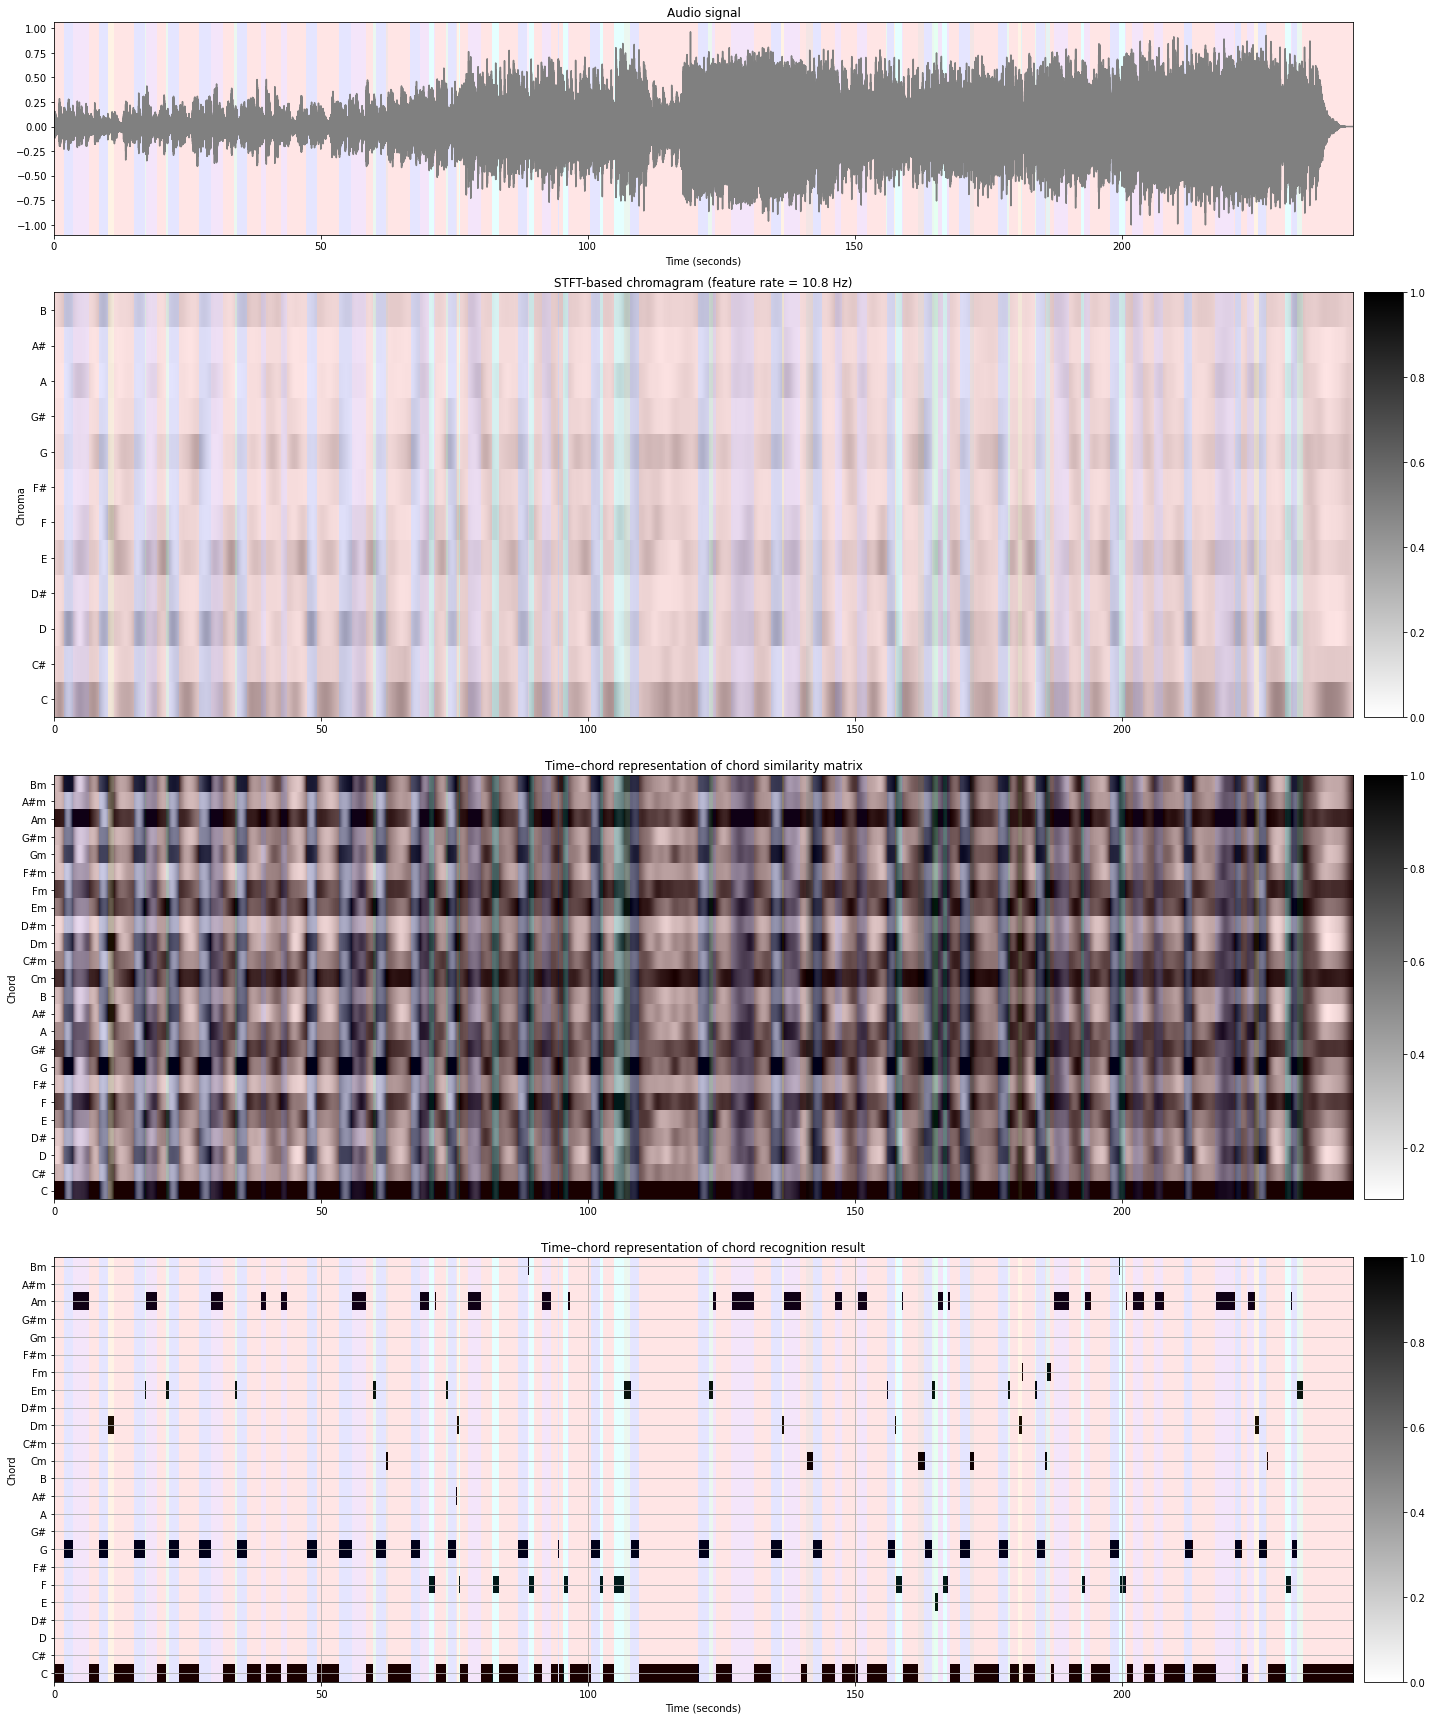

In [38]:
# Perform chords recognition
let_it_be_song = songs_dictionary[0]
recognized_chord_labels, chord_max, chord_similarity, chroma_features, chroma_feature_rate, triads_template, audio_file, audio_duration = compute_template_based_chord_recognition(let_it_be_song['audio_file'])

# Annotations in seconds
time_frames_number = len(recognized_chord_labels)
time_axis = np.arange(time_frames_number) / chroma_feature_rate
chord_annotation_seconds = []
for i in range(1, time_frames_number):
    start = time_axis[i - 1]
    end = time_axis[i]
    chord_annotation_seconds = chord_annotation_seconds + [(start, end, recognized_chord_labels[i - 1])]

# Figure configuration
fig, ax = plt.subplots(4, 2, figsize=(20, 24), gridspec_kw={'width_ratios': [1, 0.03], 'height_ratios': [1.5, 3, 3, 3]})

# Plot audio signal
libfmp.b.plot_signal(audio_file, sample_rate, ax=ax[0,0], title='Audio signal')
libfmp.b.plot_segments_overlay(chord_annotation_seconds, ax=ax[0,0], time_max=audio_duration, print_labels=False, colors=color_ann, alpha=0.1)
ax[0,1].axis('off')

# Plot chromagram
title = 'STFT-based chromagram (feature rate = %0.1f Hz)' % chroma_feature_rate
libfmp.b.plot_chromagram(chroma_features, ax=[ax[1,0], ax[1,1]], Fs=chroma_feature_rate, clim=[0, 1], xlabel='', title=title)
libfmp.b.plot_segments_overlay(chord_annotation_seconds, ax=ax[1,0], time_max=audio_duration,  print_labels=False, colors=color_ann, alpha=0.1)

# Plot similarity matrix
title = 'Time–chord representation of chord similarity matrix'
libfmp.b.plot_matrix(chord_similarity, ax=[ax[2, 0], ax[2, 1]], Fs=chroma_feature_rate, title=title, ylabel='Chord', xlabel='')
ax[2, 0].set_yticks(np.arange(len(chord_labels)))
ax[2, 0].set_yticklabels(chord_labels)
libfmp.b.plot_segments_overlay(chord_annotation_seconds, ax=ax[2, 0], time_max=audio_duration, print_labels=False, colors=color_ann, alpha=0.1)

# Plot chord recognition results
title = 'Time–chord representation of chord recognition result'
libfmp.b.plot_matrix(chord_max, ax=[ax[3, 0], ax[3, 1]], Fs=chroma_feature_rate, title=title, ylabel='Chord', xlabel='')
ax[3, 0].set_yticks(np.arange(len(chord_labels)))
ax[3, 0].set_yticklabels(chord_labels)
ax[3, 0].grid()
libfmp.b.plot_segments_overlay(chord_annotation_seconds, ax=ax[3, 0], time_max=audio_duration, print_labels=False, time_label='Time (seconds)', colors=color_ann, alpha=0.1)

plt.tight_layout()

<h2>Question 2</h2>

<h3>Ground truth processing functions</h3>

In [39]:
def read_csv(csv_file_path):

    ground_truth_csv = pandas.read_csv(csv_file_path, sep=',', keep_default_na=False, header=0)

    segment_annotation_indices = []
    segment_annotation_seconds = []
    for i, (start_seconds, end_seconds, chord_label) in ground_truth_csv.iterrows():
        start_index = int(np.round(start_seconds * chroma_feature_rate))
        end_index = int(np.round(end_seconds * chroma_feature_rate))
        segment_annotation_indices.append([start_index, end_index, chord_label])
        segment_annotation_seconds.append((start_seconds, end_seconds, chord_label))

    return segment_annotation_indices, segment_annotation_seconds

def convert_segment_annotations(segment_annotation_indices):

    frame_labels_sequence = []
    for segment in segment_annotation_indices:
        segment_indices_count = segment[1] - segment[0]
        for k in range(segment_indices_count):
            frame_labels_sequence.append(segment[2])

    # Pad frame label sequence with the last chord to match number of frames if needed
    frame_labels_sequence_padding = chord_max.shape[1] - len(frame_labels_sequence)
    for i in range(frame_labels_sequence_padding):
        frame_labels_sequence.append(frame_labels_sequence[-1])

    return frame_labels_sequence

def get_binary_time_chord_matrix(labels_sequence):

    time_chord_matrix = np.zeros((len(chord_labels), len(labels_sequence)))
    for i in range(time_chord_matrix.shape[1]):
        chord_label = labels_sequence[i]
        if chord_label in chord_labels:
            label_index = chord_labels.index(chord_label)
            time_chord_matrix[label_index, i] = 1

    return time_chord_matrix

def normalize_annotation_chord_labels(annotations):
    """Replace for segment-based annotation in each chord label the string ':min' by 'm'
    and convert flat chords into sharp chords using enharmonic equivalence

    Args:
        annotations (list): Segment-based annotation with chord labels

    Returns:
        normalized_annotations (list): Converted segment-based annotation with chord labels
    """

    normalized_annotations = []
    is_tuple_annotation = type(annotations[0]) is tuple

    for i in range(len(annotations)):
        current_annotation = annotations[i]
        normalized_annotation = list(current_annotation) if is_tuple_annotation else current_annotation
        normalized_annotation[2] = normalized_annotation[2].replace('Db', 'C#')
        normalized_annotation[2] = normalized_annotation[2].replace('Fb', 'E')
        normalized_annotation[2] = normalized_annotation[2].replace('Eb', 'D#')
        normalized_annotation[2] = normalized_annotation[2].replace('Gb', 'F#')
        normalized_annotation[2] = normalized_annotation[2].replace('Ab', 'G#')
        normalized_annotation[2] = normalized_annotation[2].replace('Bb', 'A#')
        normalized_annotation[2] = normalized_annotation[2].replace('Cb', 'B')
        normalized_annotation[2] = re.sub(r':(min|hdim|dim)\d{0,2}\(?[b#]?\d{0,2}\)?', 'm', normalized_annotation[2])
        normalized_annotation[2] = re.sub(r':(maj|sus)?\d{0,2}\(?[b#]?\d{0,2}\)?', '', normalized_annotation[2])
        normalized_annotation[2] = re.sub(r':?\/[b#]?\d{0,2}', '', normalized_annotation[2])
        normalized_annotation = tuple(normalized_annotation) if is_tuple_annotation else normalized_annotation
        normalized_annotations.append(normalized_annotation)

    return normalized_annotations

<h3>Ground truth reading implementation</h3>

In [40]:
def read_ground_truth(csv_file_path):
    """Convert segment-based chord annotation into various formats

    Args:
        csv_file_path (str): Filename of segment-based chord annotation

    Returns:
        ann_matrix (np.ndarray): Encoding of label sequence in form of a binary time-chord representation
        ann_frame (list): Label sequence (specified on the frame level)
    """

    orig_segment_annotation_indices, orig_segment_annotation_seconds = read_csv(csv_file_path)
    norm_segment_annotation_indices = normalize_annotation_chord_labels(orig_segment_annotation_indices)
    norm_segment_annotation_seconds = normalize_annotation_chord_labels(orig_segment_annotation_seconds)

    ground_truth_chord_labels = convert_segment_annotations(norm_segment_annotation_indices)
    ground_truth_time_chord_matrix = get_binary_time_chord_matrix(ground_truth_chord_labels)

    return ground_truth_chord_labels, ground_truth_time_chord_matrix, orig_segment_annotation_seconds, norm_segment_annotation_seconds

<h3>Let It Be - Perform ground truth reading</h3>

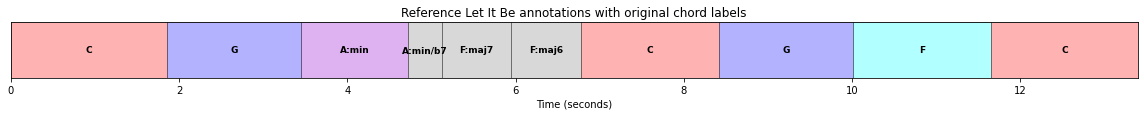

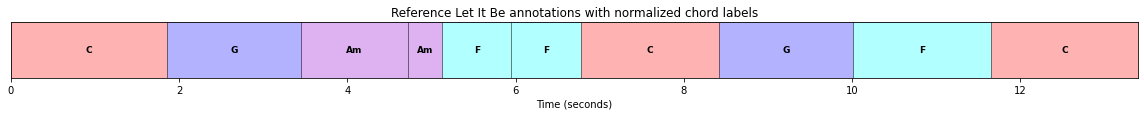

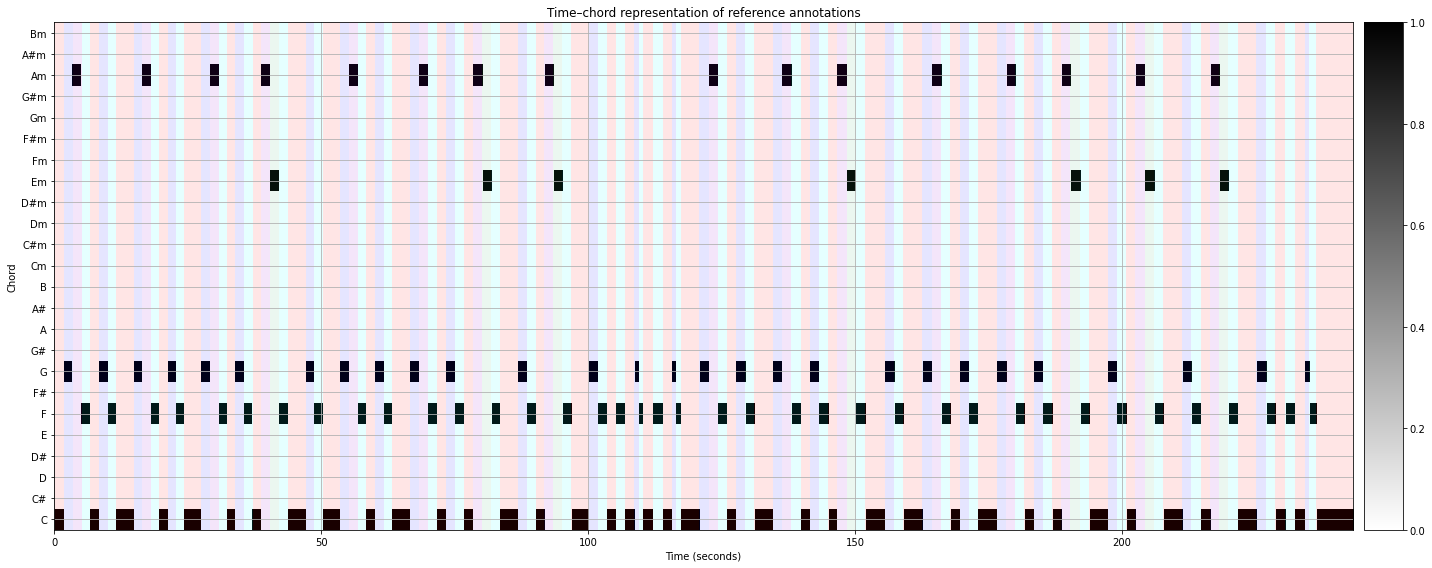

In [41]:
# Perform ground truth reading
ground_truth_chord_labels, ground_truth_time_chord_matrix, original_chord_labels, normalized_chord_labels = read_ground_truth(let_it_be_song['reference_annotations_file'])

# Plots

# Plot first elements of original vs. normalized chord labels
libfmp.b.plot_segments(original_chord_labels[:10], figsize=(16, 1.5), time_label='Time (seconds)', fontsize=9, colors=color_ann, alpha=0.3)
plt.title('Reference %s annotations with original chord labels' % 'Let It Be')
plt.show()
libfmp.b.plot_segments(normalized_chord_labels[:10], figsize=(16, 1.5), time_label='Time (seconds)', fontsize=9, colors=color_ann, alpha=0.3)
plt.title('Reference %s annotations with normalized chord labels' % 'Let It Be')
plt.show()

# Plot ground truth time-chord representation
fig, ax = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [1, 0.03], 'height_ratios': [2]})

title='Time–chord representation of reference annotations'
libfmp.b.plot_matrix(ground_truth_time_chord_matrix, ax=[ax[0], ax[1]], Fs=chroma_feature_rate, title=title, ylabel='Chord', xlabel='')
ax[0].set_yticks(np.arange(len(chord_labels)))
ax[0].set_yticklabels(chord_labels)
libfmp.b.plot_segments_overlay(normalized_chord_labels, ax=ax[0], time_max=audio_duration, print_labels=False, time_label='Time (seconds)', colors=color_ann, alpha=0.1)
ax[0].grid()

plt.tight_layout()

<h2>Question 3</h2>

<h3>Metric evaluation implementation</h3>

In [42]:
def compute_evaluation_measures(chord_max, ground_truth_matrix):
    """Compute evaluation measures

    Args:
        ground_truth_matrix (np.ndarray): Reference set of items
        chord_max (np.ndarray): Set of estimated items

    Returns:
        precision (float): Precision
        true_positive (int): Number of true positives
        false_positive (int): Number of false positives
        false_negative (int): Number of false negatives
    """
    assert ground_truth_matrix.shape == chord_max.shape, "Dimension of input matrices must agree"
    true_positive = np.sum(np.logical_and(ground_truth_matrix, chord_max))
    false_positive = np.sum(chord_max > 0, axis=None) - true_positive
    false_negative = np.sum(ground_truth_matrix > 0, axis=None) - true_positive
    precision = 0
    if true_positive > 0:
        precision = true_positive / (true_positive + false_positive)
    return precision, true_positive, false_positive, false_negative

<h3>Let It Be - Perform metric evaluation</h3>

Let It Be - Recognition precision: 60.27%


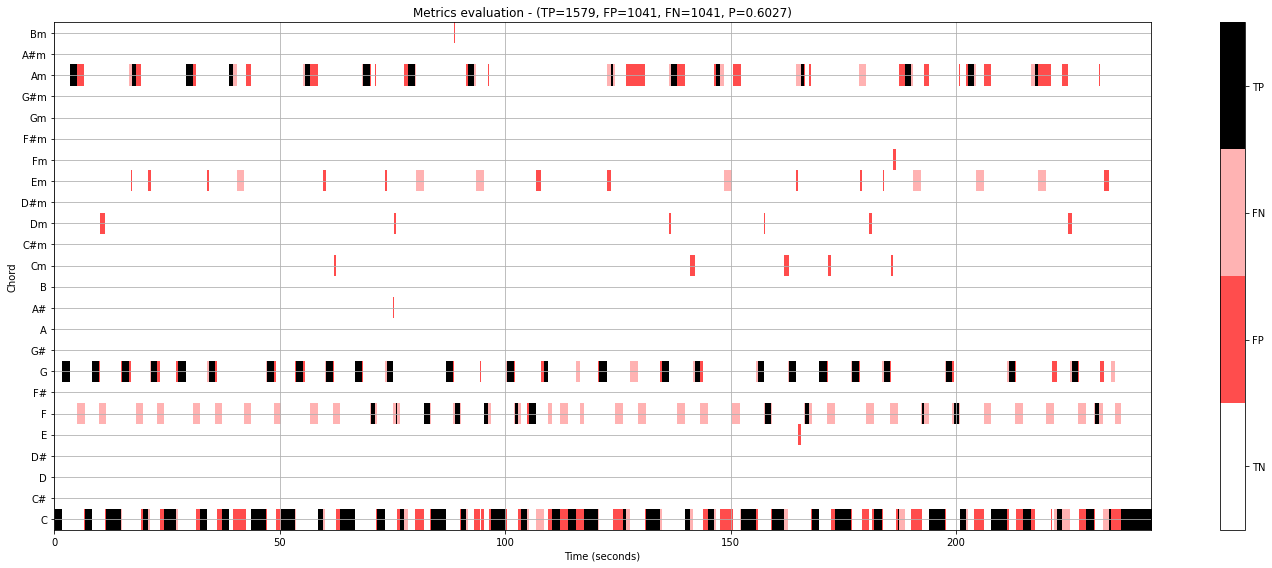

In [43]:
recognition_precision, true_positive, false_positive, false_negative = compute_evaluation_measures(chord_max, ground_truth_time_chord_matrix)

print('===================================================')
print('{} - Recognition precision: {}%'.format(let_it_be_song['title'], round(recognition_precision * 100, 2)))
print('===================================================')

# Plot measures evaluation
title = 'Metrics evaluation - (TP=%d, FP=%d, FN=%d, P=%.4f)' % (true_positive, false_positive, false_negative, recognition_precision)
fig, ax, im = libfmp.c5.plot_matrix_chord_eval(ground_truth_time_chord_matrix, chord_max, Fs=chroma_feature_rate, figsize=(20, 8), title=title, ylabel='Chord', xlabel='Time (seconds)', chord_labels=chord_labels)
plt.tight_layout()
plt.show()

<h2>Question 4</h2>

<h3>Perform metric evaluation for other songs</h3>

Here Comes The Sun - Recognition precision: 53.68%


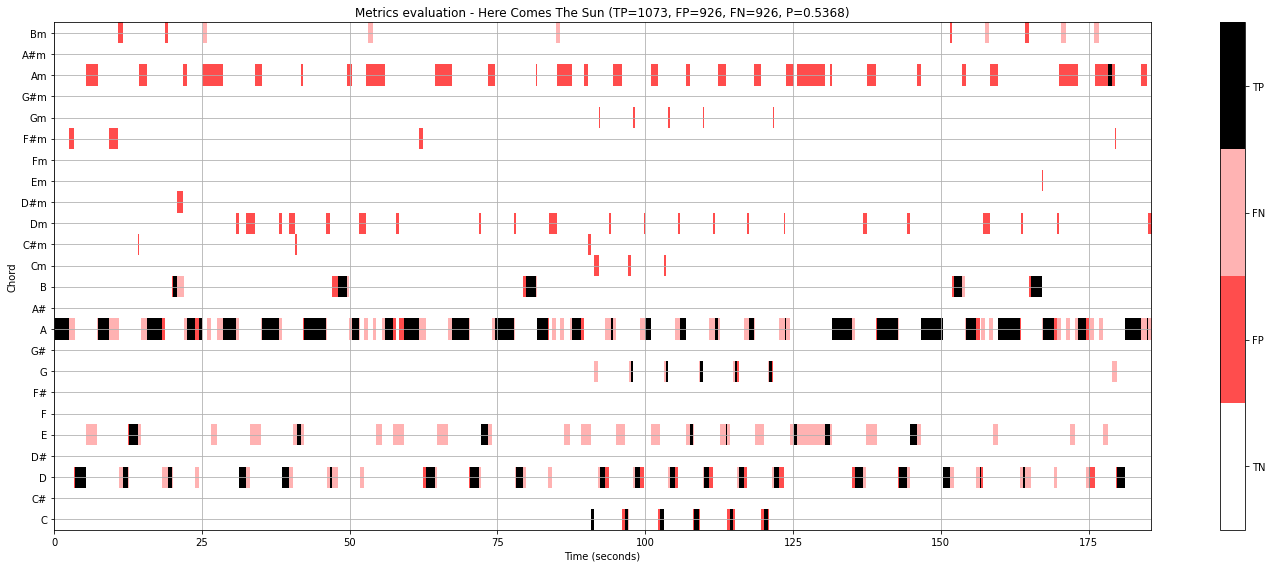

ObLaDi ObLaDa - Recognition precision: 73.4%


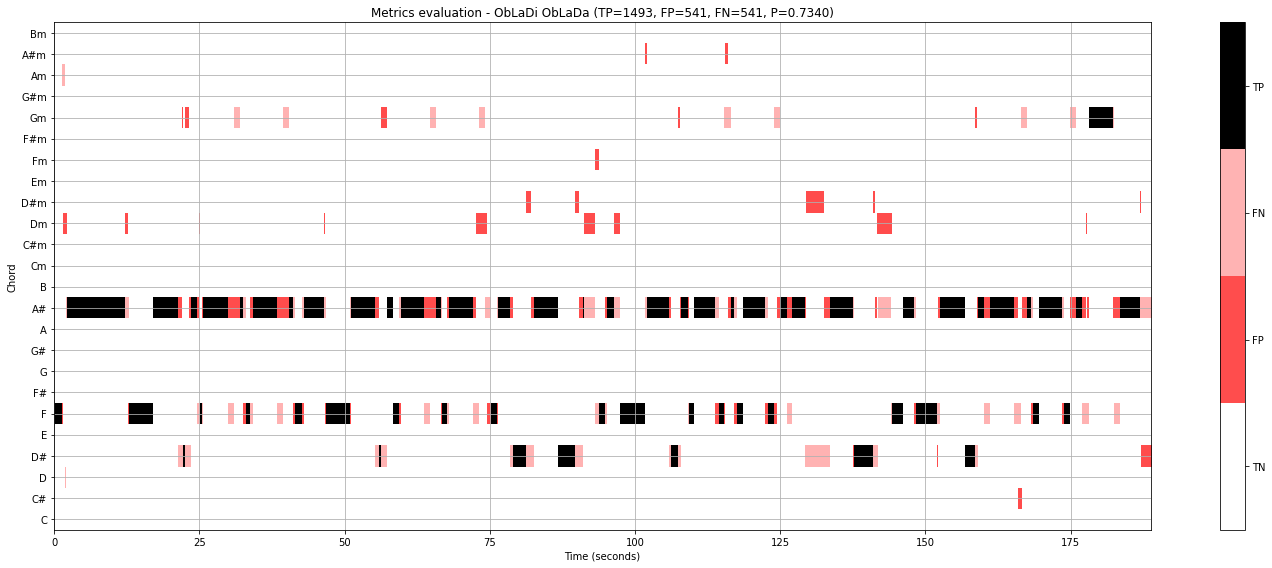

Penny Lane - Recognition precision: 54.57%


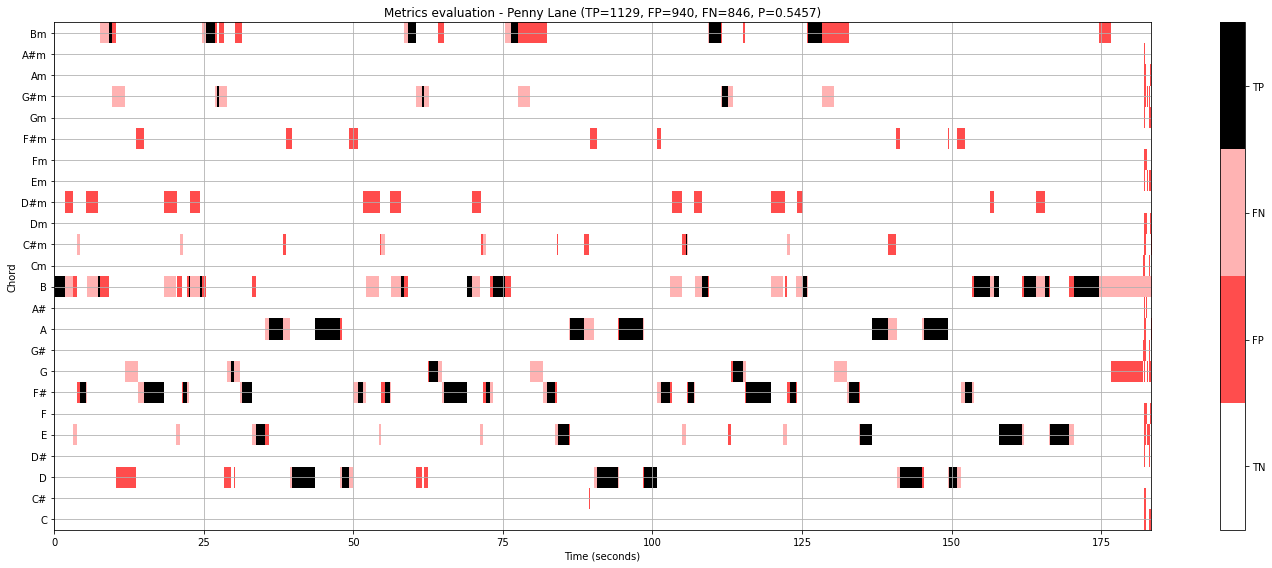

In [44]:
for song in songs_dictionary.values():
    if song['title'] != let_it_be_song['title']:

        # Perform chords recognition
        recognized_chord_labels, chord_max, chord_similarity, chroma_features, chroma_feature_rate, triads_template, audio_file, audio_duration = compute_template_based_chord_recognition(song['audio_file'])

        # Read ground truth
        ground_truth_chord_labels, ground_truth_time_chord_matrix, original_chord_labels, normalized_chord_labels = read_ground_truth(song['reference_annotations_file'])

        # Compute metrics evaluation
        recognition_precision, true_positive, false_positive, false_negative = compute_evaluation_measures(chord_max, ground_truth_time_chord_matrix)

        print('===================================================')
        print('{} - Recognition precision: {}%'.format(song['title'], round(recognition_precision * 100, 2)))
        print('===================================================')

        # Plot measures evaluation
        title = 'Metrics evaluation - %s (TP=%d, FP=%d, FN=%d, P=%.4f)' % (song['title'], true_positive, false_positive, false_negative, recognition_precision)
        fig, ax, im = libfmp.c5.plot_matrix_chord_eval(ground_truth_time_chord_matrix, chord_max, Fs=chroma_feature_rate, figsize=(20, 8), title=title, ylabel='Chord', xlabel='Time (seconds)', chord_labels=chord_labels)
        plt.tight_layout()
        plt.show()

<h2>Question 5</h2>

<h3>Compute metrics evaluation on parameters change</h3>

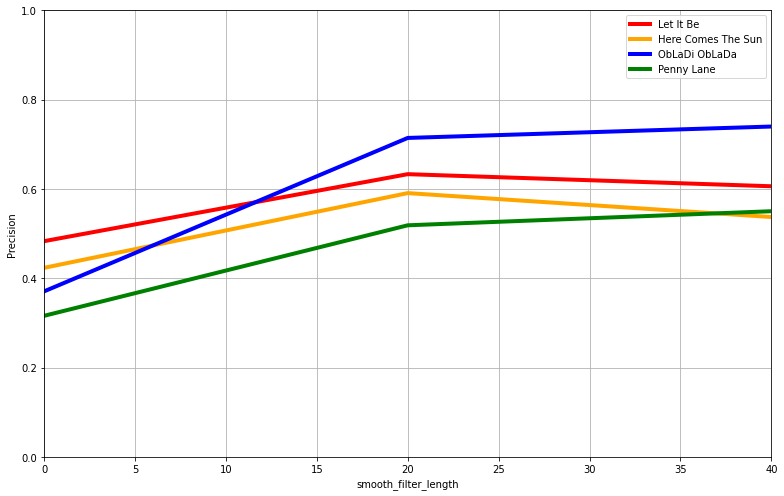

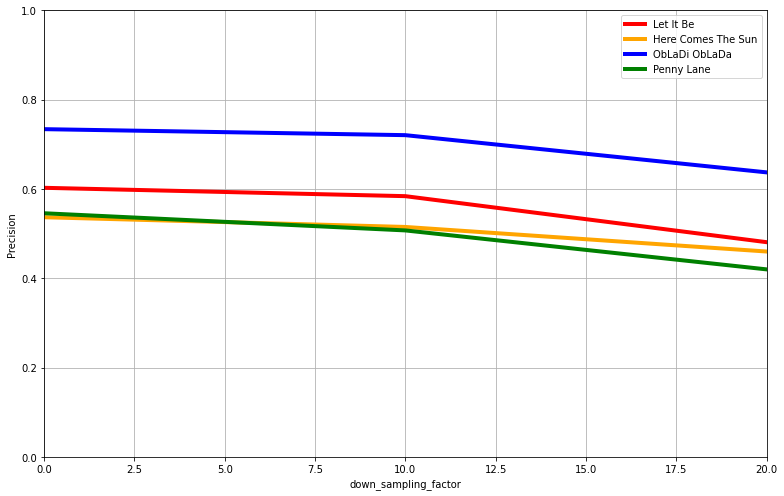

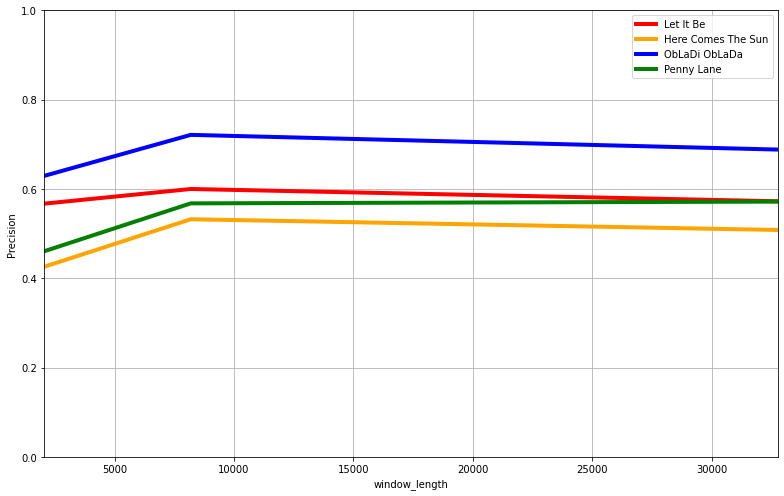

In [45]:
parameters_values = {
    'smooth_filter_length': [0, 20, 40],
    'down_sampling_factor': [0, 10, 20],
    'window_length': [2048, 8192, 32768]
}

for parameter, values in parameters_values.items():
    # Save default value
    parameter_default_value = globals()[parameter]

    for song in songs_dictionary.values():
        for parameter_value in values:
            globals()[parameter] = parameter_value

            # Perform chords recognition
            recognized_chord_labels, chord_max, chord_similarity, chroma_features, chroma_feature_rate, triads_template, audio_file, audio_duration = compute_template_based_chord_recognition(song['audio_file'])
            
            # Read ground truth
            ground_truth_chord_labels, ground_truth_time_chord_matrix, original_chord_labels, normalized_chord_labels = read_ground_truth(song['reference_annotations_file'])

            # Compute metrics evaluation
            recognition_precision, true_positive, false_positive, false_negative = compute_evaluation_measures(chord_max, ground_truth_time_chord_matrix)

            # Save results in song's dictionary
            song['parameter_evaluation_results'][parameter]['precision'].append(recognition_precision)
            song['parameter_evaluation_results'][parameter]['true_positive'].append(true_positive)
            song['parameter_evaluation_results'][parameter]['false_positive'].append(false_positive)
            song['parameter_evaluation_results'][parameter]['false_negative'].append(false_negative)
    
    plot_parameter_test_results(parameter)
    
    # Restore default value before next iteration
    globals()[parameter] = parameter_default_value
